### O trabalho a seguir visa simplesmente criar um modelo preditivo de preços de algumas das commodities mais exportadas pelo Brasil. A ideia é simplesmente criar um modelo básico de previsão de preços com base em dois parâmetros: volatilidade e média móvel de preços. A base de dados utilizada são os preços dos últimos 20 anos.

### Ficou bastante interessante.

--

### Bibliotecas que utilizarei

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

### Lista de produtos que buscarei os preços

In [20]:
commodities = [
    "SB=F",  # Sugar
    "ZS=F",  # Soybeans
    "ZC=F",  # Corn
    "ZW=F",  # Wheat
    "KC=F",  # Coffee
    "GC=F",  # Gold
    "CL=F",  # Crude Oil
    "LBS=F",  # Lumber
    "HG=F",  # Copper
    "LE=F"   # Live Cattle
]

#vou criar um dicionário
commodities_dict = {
    "SB=F": "Sugar",
    "ZS=F": "Soybeans",
    "ZC=F": "Corn",
    "ZW=F": "Wheat",
    "KC=F": "Coffee",
    "GC=F": "Gold",
    "CL=F": "Crude Oil",
    "LBS=F": "Lumber",
    "HG=F": "Copper",
    "LE=F": "Live Cattle"
}

#Crio um dataframe vazio onde armazenarei os dados:

In [21]:
df = pd.DataFrame()

### Baixar os dados de fechamento para cada commodity e armazenar no DataFrame df

In [22]:
start = dt.datetime(2003, 1, 2)
end = dt.datetime(2024, 9, 20)

for commodity in commodities:
    try:
        data = yf.download(commodity, start=start, end=end)['Close']
        # Renomear a coluna do DataFrame para incluir o ticker
        data = data.rename(commodity)
        #Concateno os dataframes gerados em um só:
        df = pd.concat([df, data], axis=1)
    except Exception as e:
        print(f"Erro ao baixar dados para {commodity}: {e}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Resetar o índice para incluir a coluna de datas no DataFrame

In [23]:
df.reset_index(inplace=True)
#renomear a coluna
df.rename(columns={'index': 'date'}, inplace=True)

### Mostrar as primeiras linhas do DataFrame

In [24]:
#vou renomear as colunas do df de acordo com o dicionário
df.rename(columns=commodities_dict, inplace=True)
df.head()

,date,Sugar,Soybeans,Corn,Wheat,Coffee,Gold,Crude Oil,Lumber,Copper,Live Cattle
0,2003-01-02,7.69,584.50,237.00,328.75,61.650002,346.100006,31.850000,217.000000,0.7140,79.400002
1,2003-01-03,7.40,582.25,236.00,330.50,61.250000,351.200012,33.080002,219.399994,0.7265,79.974998
2,2003-01-06,7.61,582.00,235.75,331.50,63.250000,351.700012,32.099998,220.699997,0.7345,79.625000
3,2003-01-07,7.55,585.25,240.00,327.75,63.500000,347.299988,31.080000,221.399994,0.7315,79.675003
4,2003-01-08,7.74,589.50,245.25,337.00,62.849998,353.899994,30.559999,225.199997,0.7420,79.599998


In [25]:
#vou verificar valores nulos no dataframe, exceto no coluna date
df.isnull().sum()

#vou remover os valores nan
df.dropna(inplace=True)

In [26]:
df

,date,Sugar,Soybeans,Corn,Wheat,Coffee,Gold,Crude Oil,Lumber,Copper,Live Cattle
0,2003-01-02,7.690000,584.50,237.00,328.75,61.650002,346.100006,31.850000,217.000000,0.7140,79.400002
1,2003-01-03,7.400000,582.25,236.00,330.50,61.250000,351.200012,33.080002,219.399994,0.7265,79.974998
2,2003-01-06,7.610000,582.00,235.75,331.50,63.250000,351.700012,32.099998,220.699997,0.7345,79.625000
3,2003-01-07,7.550000,585.25,240.00,327.75,63.500000,347.299988,31.080000,221.399994,0.7315,79.675003
4,2003-01-08,7.740000,589.50,245.25,337.00,62.849998,353.899994,30.559999,225.199997,0.7420,79.599998
...,...,...,...,...,...,...,...,...,...,...,...
5109,2023-05-09,26.190001,1451.75,642.25,630.50,188.000000,2036.199951,73.709999,344.000000,3.8890,163.925003
5110,2023-05-10,26.660000,1436.50,645.50,628.25,187.449997,2030.500000,72.559998,348.899994,3.8280,163.000000
5111,2023-05-11,26.020000,1443.25,632.50,614.25,185.800003,2014.699951,70.870003,345.000000,3.6975,162.949997
5112,2023-05-12,26.219999,1435.00,633.25,624.50,186.000000,2014.500000,70.040001,339.000000,3.7165,164.399994


### Vou visualizar os preços em um gráfico

### Crio uma paleta de cores:

In [10]:
#vou contar as colunas -- tirando a date
df.columns[1:]
len(df.columns[1:])

10

In [11]:
#criando uma paleta de 10 cores
colors = [
    "mediumslateblue",
    "coral",
    "forestgreen",
    "mediumvioletred",
    "tan",
    "darkgoldenrod",
    "dimgray",
    "salmon",
    "yellowgreen",
    "rebeccapurple"
]


### Ploto os dados em um gráfico:

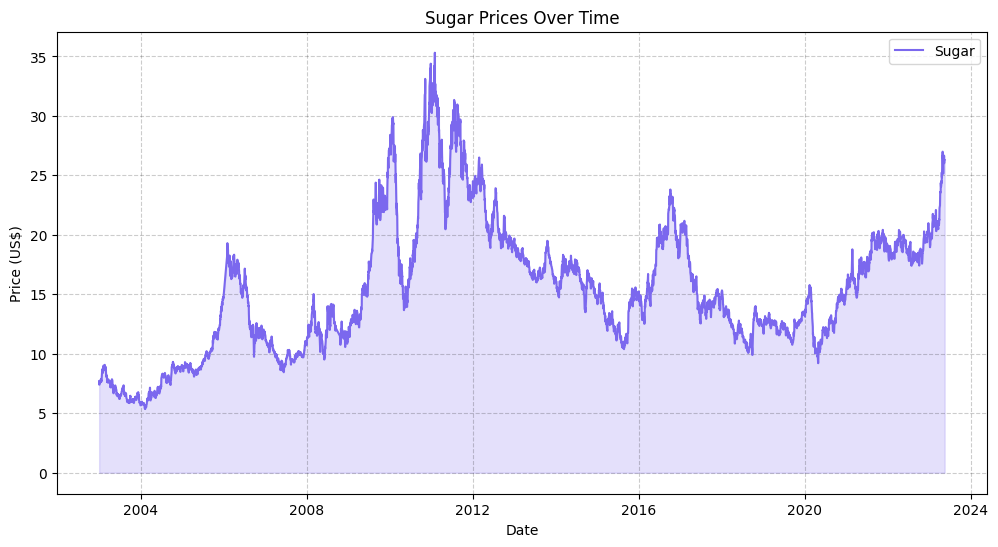

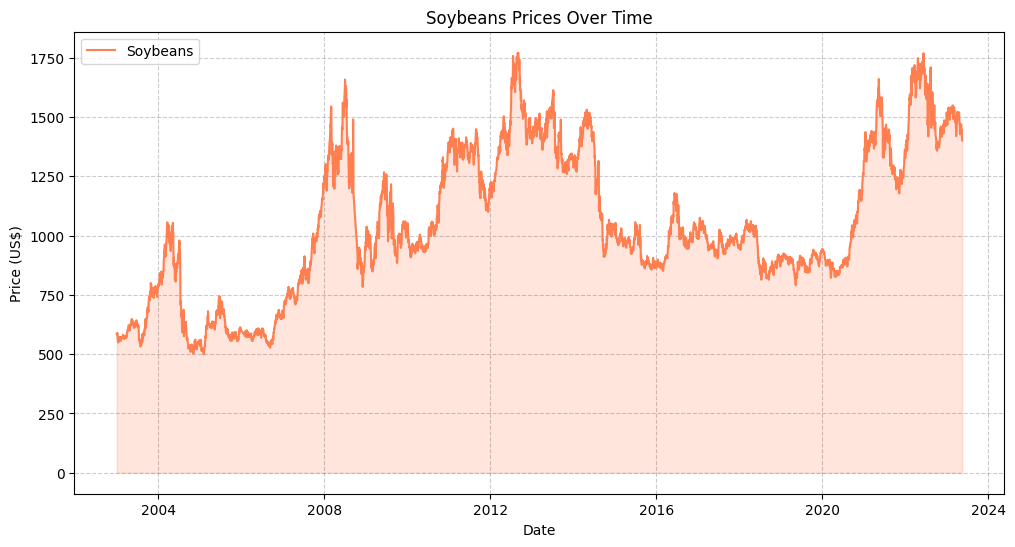

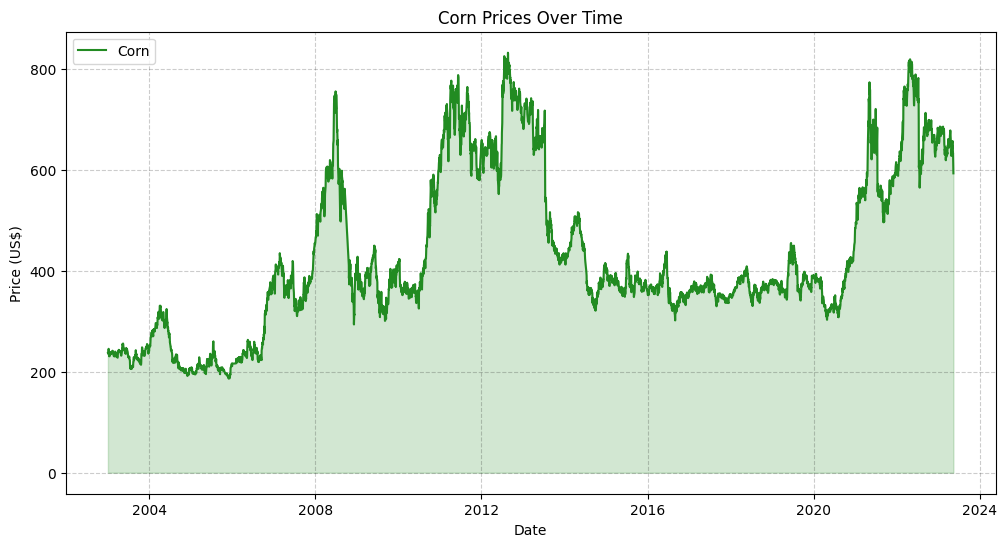

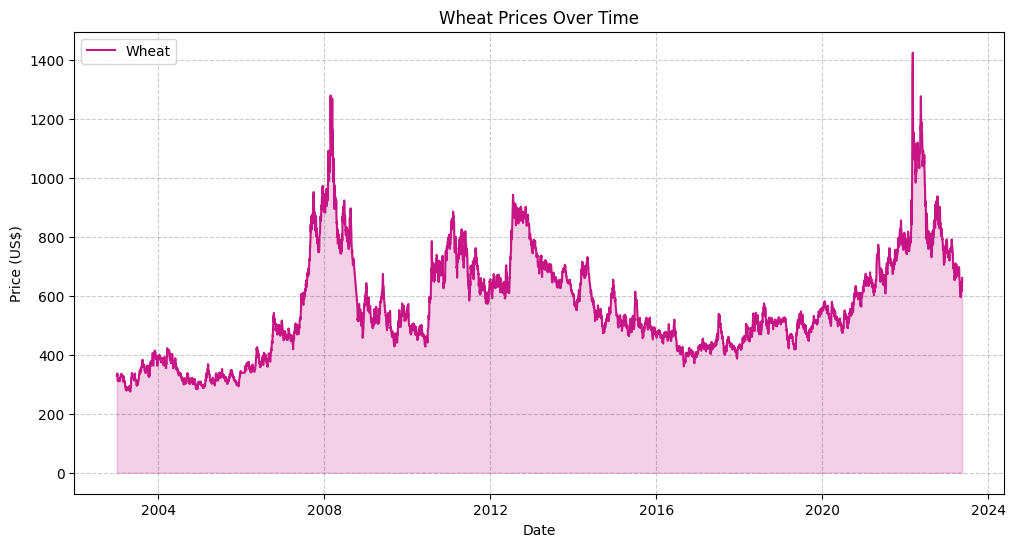

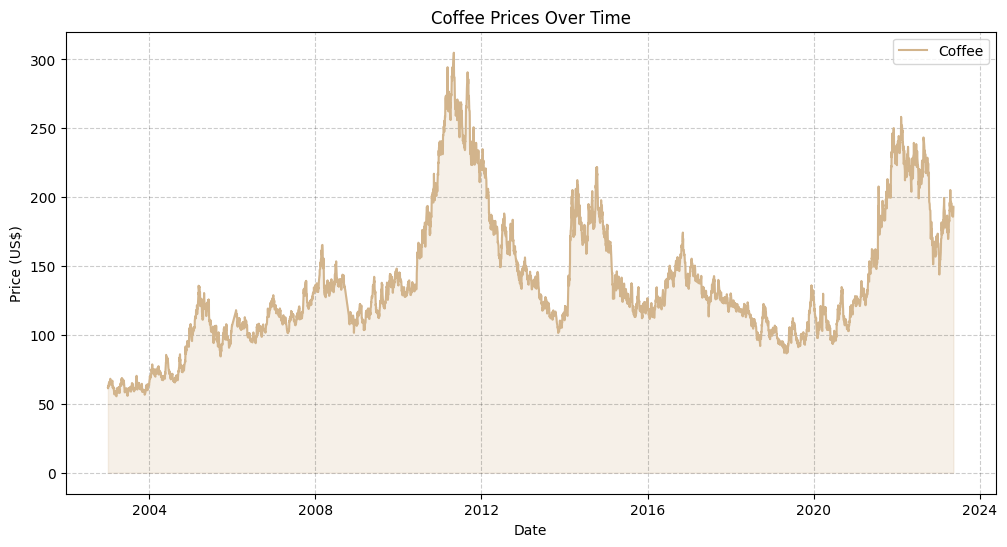

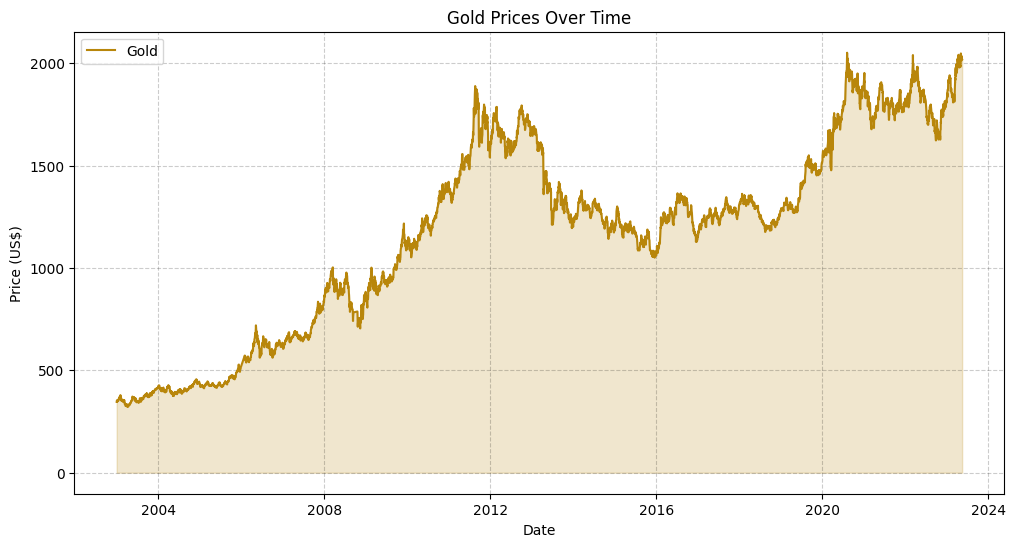

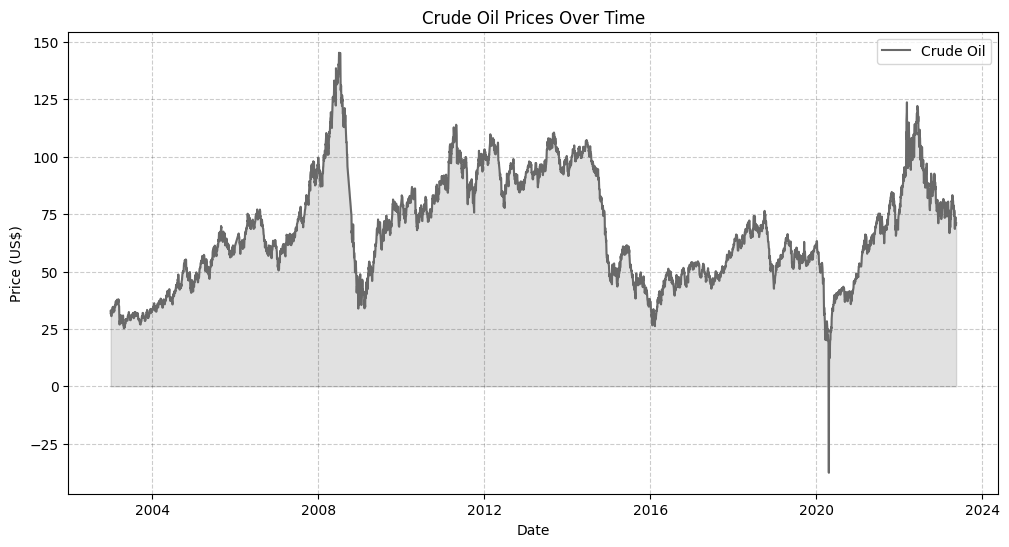

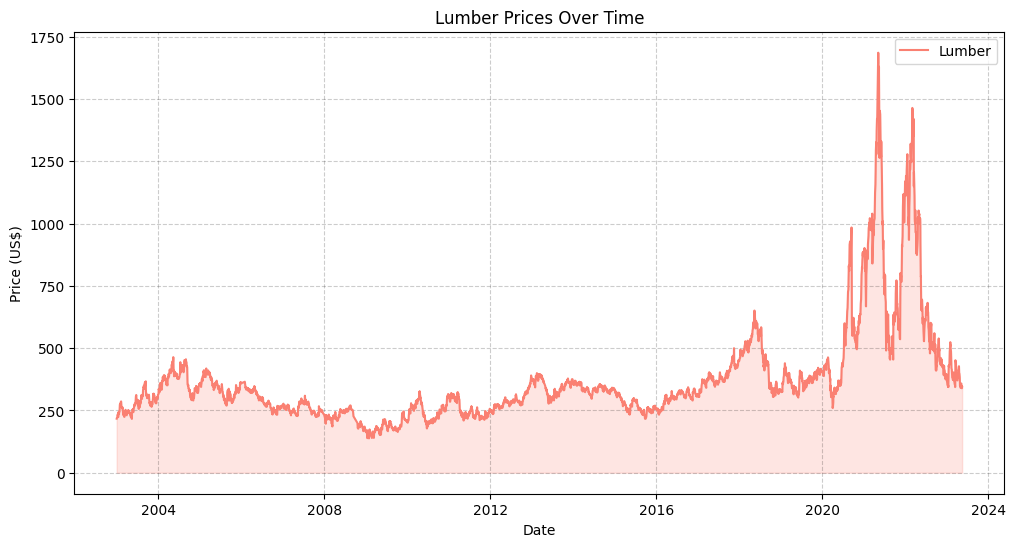

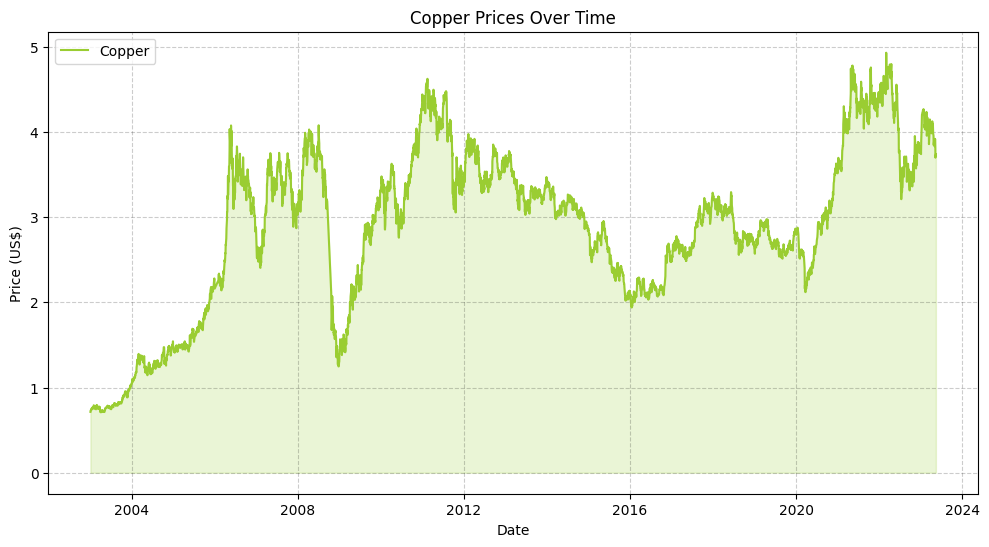

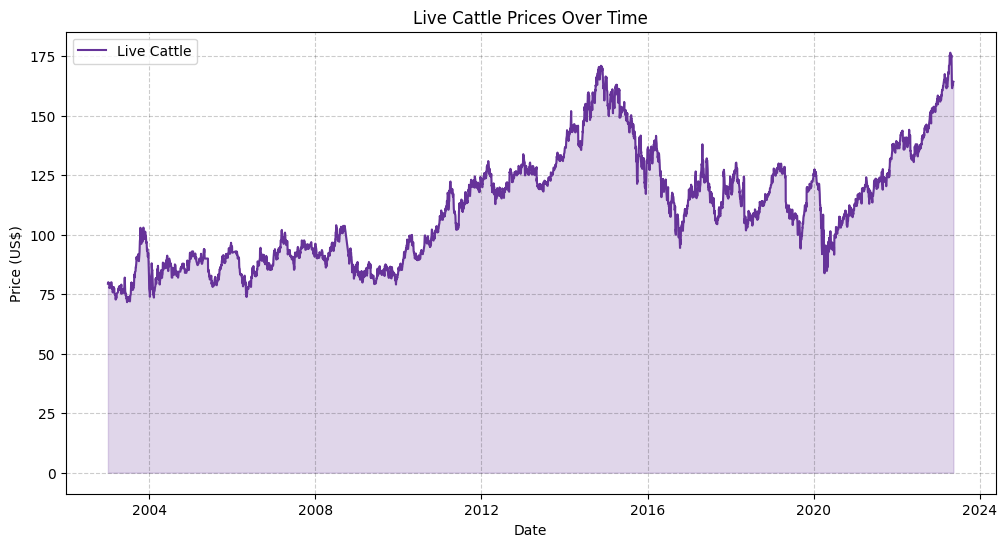

In [12]:
#vou criar um gráfico em loop para os preços
for i, commodity in enumerate(df.columns[1:]):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[commodity], label=commodity, c=colors[i])
    #vou preencher
    plt.fill_between(df['date'], df[commodity], color=colors[i], alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Price (US$)')
    plt.title(f'{commodity} Prices Over Time')
    plt.grid(True, alpha = 0.2, linestyle ="--", c ='black')
    plt.legend()
    plt.show()



---



### Visualizar a volatilidade ao longo do tempo:

In [13]:
#criando o dataframe para armazenar a volatilidade
dfv = pd.DataFrame()

In [14]:
#preencher o dataframe dfv com a data e a volatilidade
for commodity in df.columns[1:]:
    dfv[commodity] = df[commodity].rolling(window=30).std()
    dfv['date'] = df['date']
    dfv.dropna(inplace=True)
    dfv.reset_index(drop=True, inplace=True)
dfv.head()

,Sugar,date,Soybeans,Corn,Wheat,Coffee,Gold,Crude Oil,Lumber,Copper,Live Cattle
0,0.447212,2003-02-13,19.771142,6.418370,19.393840,3.286223,6.928602,1.044586,9.632764,0.019367,1.115848
1,0.427146,2003-02-14,19.607362,6.403797,20.399706,3.238143,7.382335,1.018369,9.552633,0.020891,1.197478
2,0.399212,2003-02-19,19.821589,6.376530,22.198298,3.161336,7.629322,1.005319,9.656923,0.022884,1.209854
3,0.375651,2003-02-20,21.534203,6.518040,23.970054,3.080974,7.637774,0.982760,9.870712,0.024057,1.210113
4,0.354789,2003-02-21,23.354959,6.504883,25.470798,2.971030,7.583726,0.948602,10.259608,0.024681,1.193524


### plotando em um gráfico:

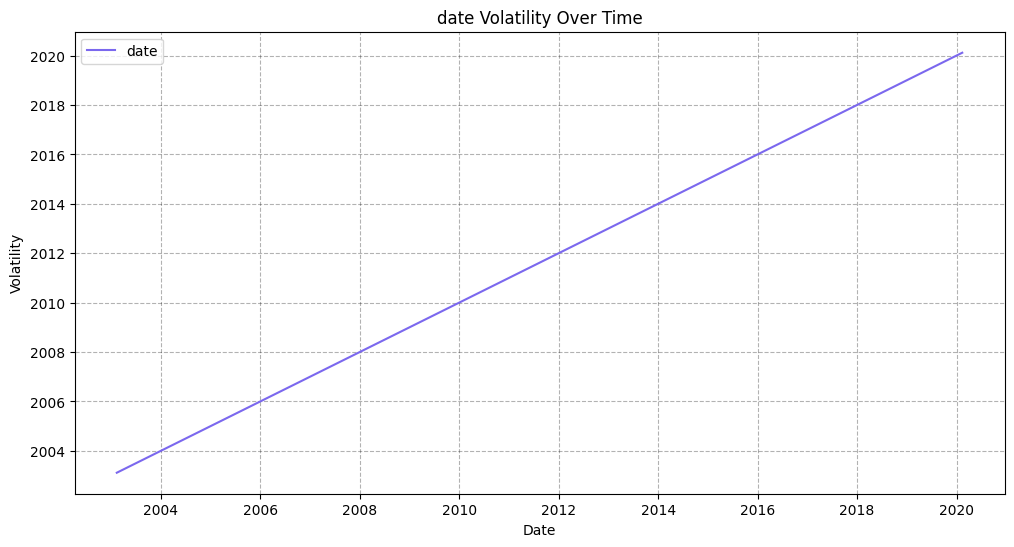

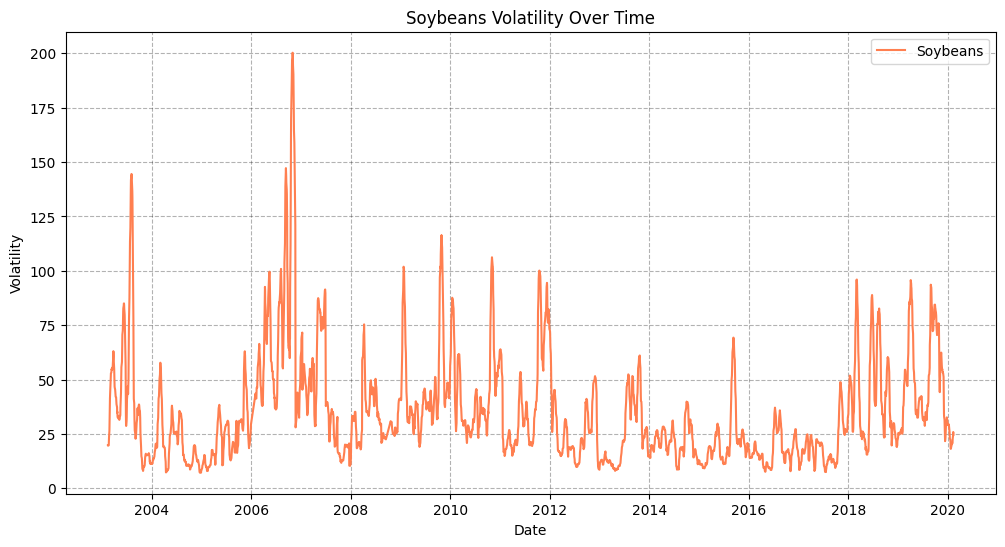

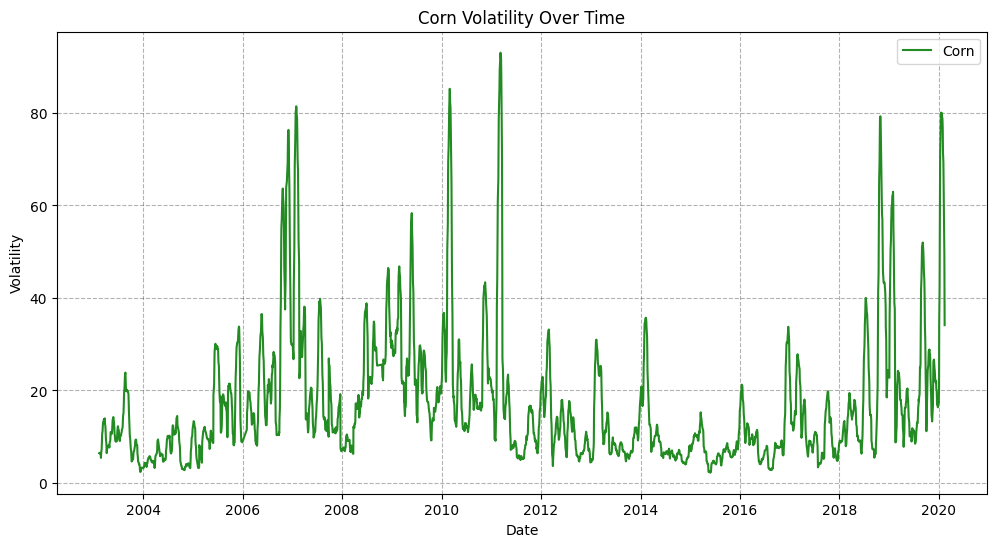

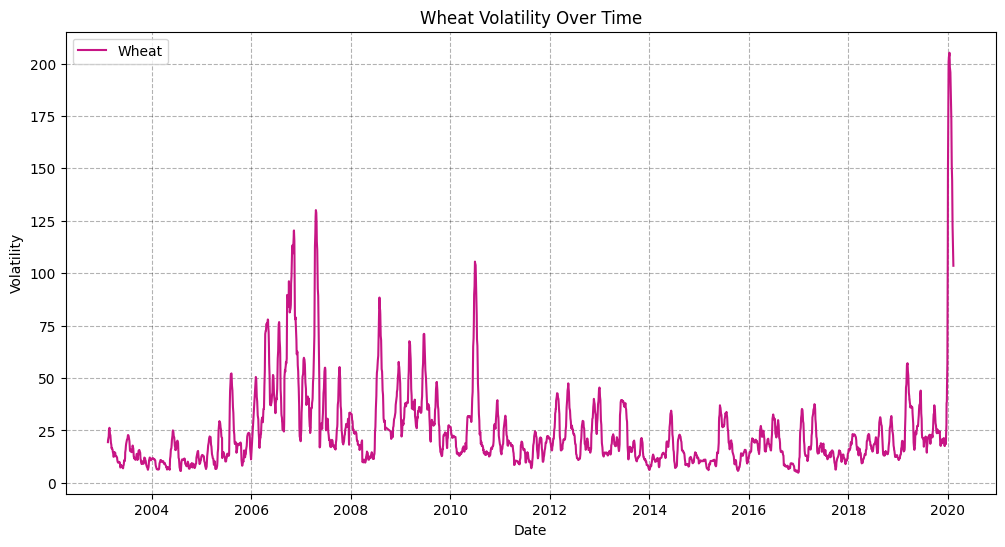

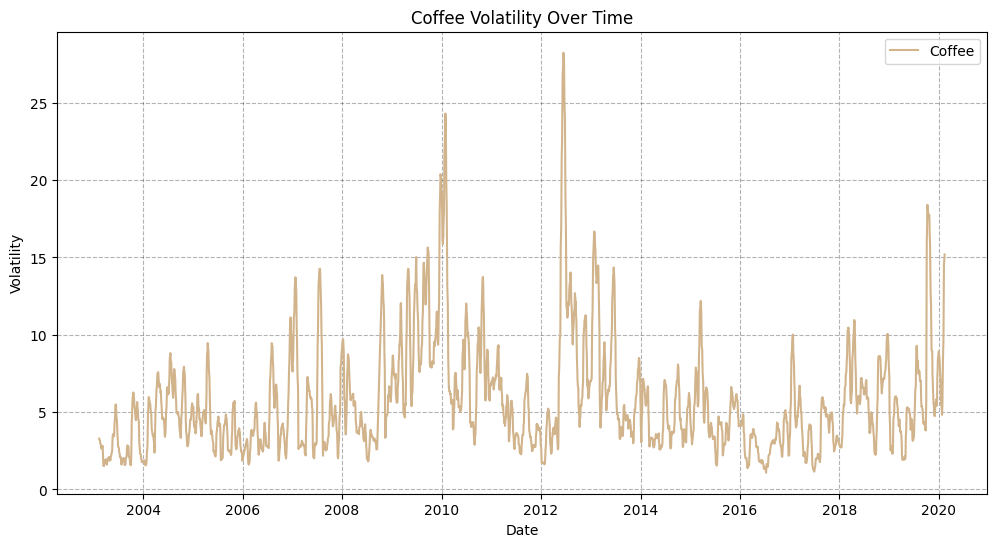

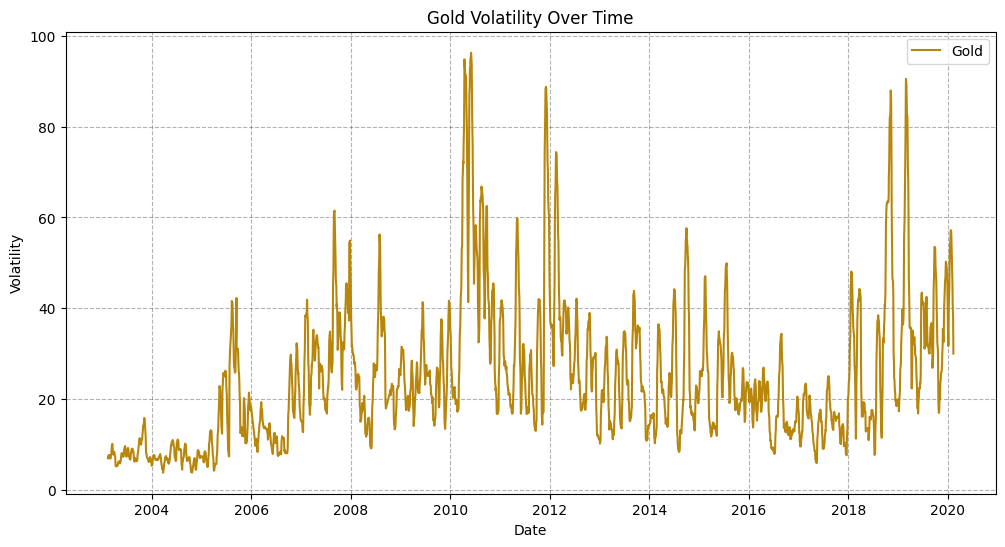

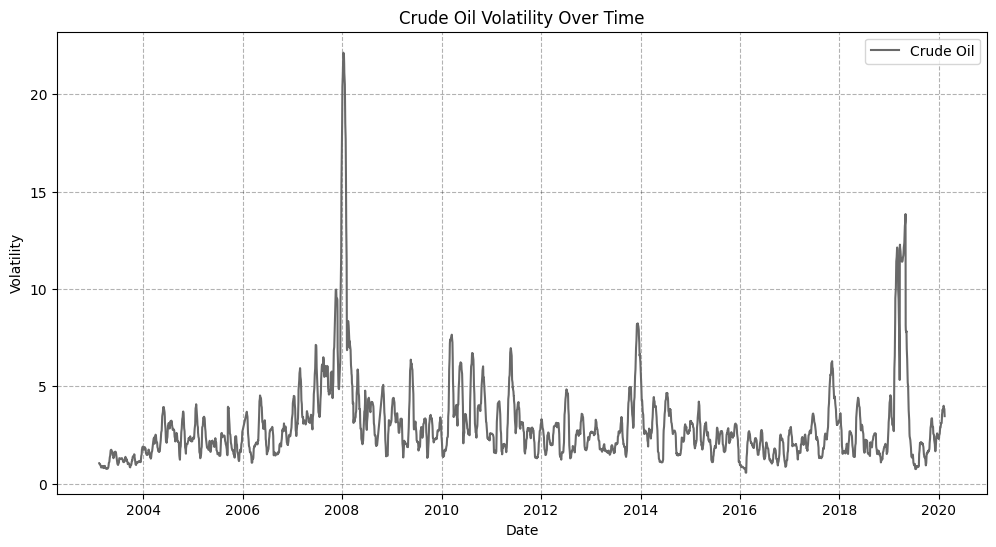

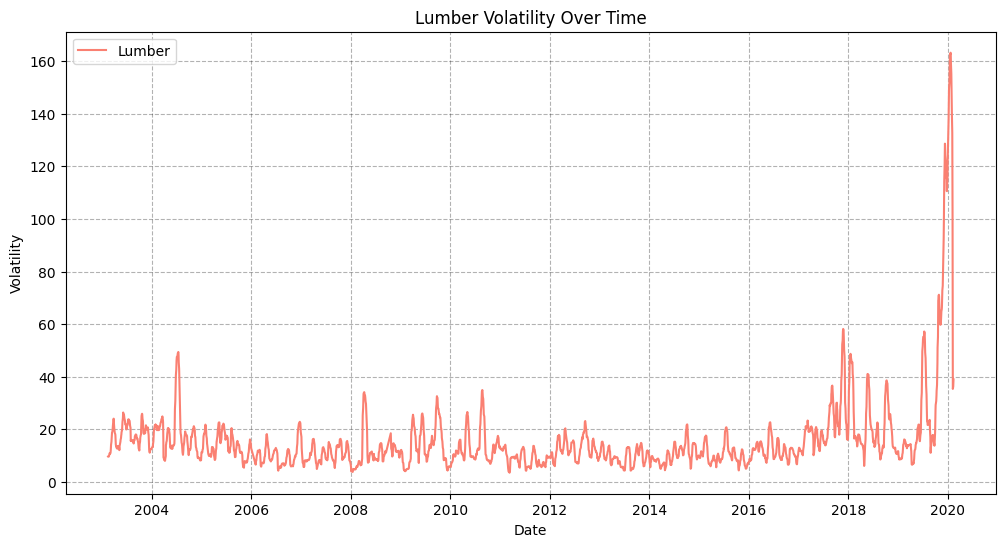

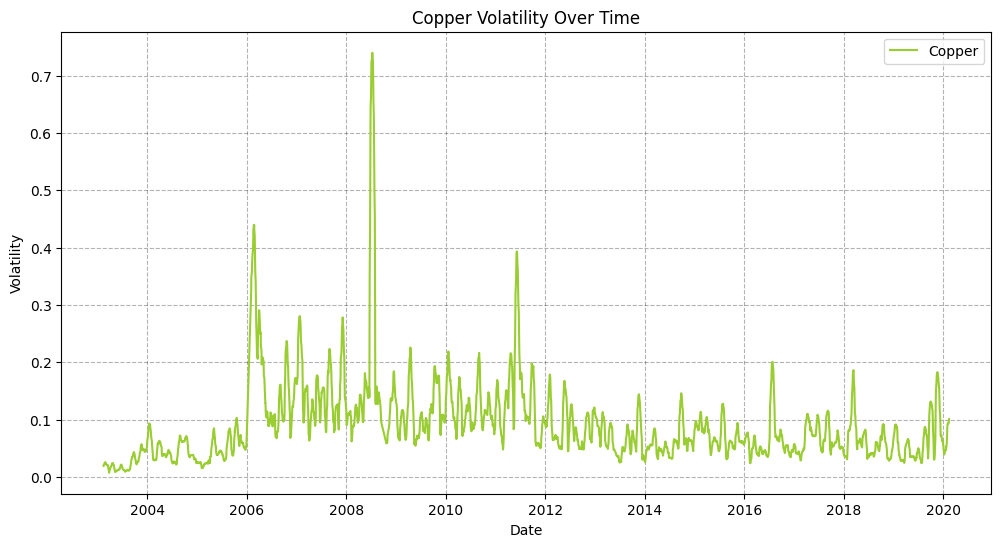

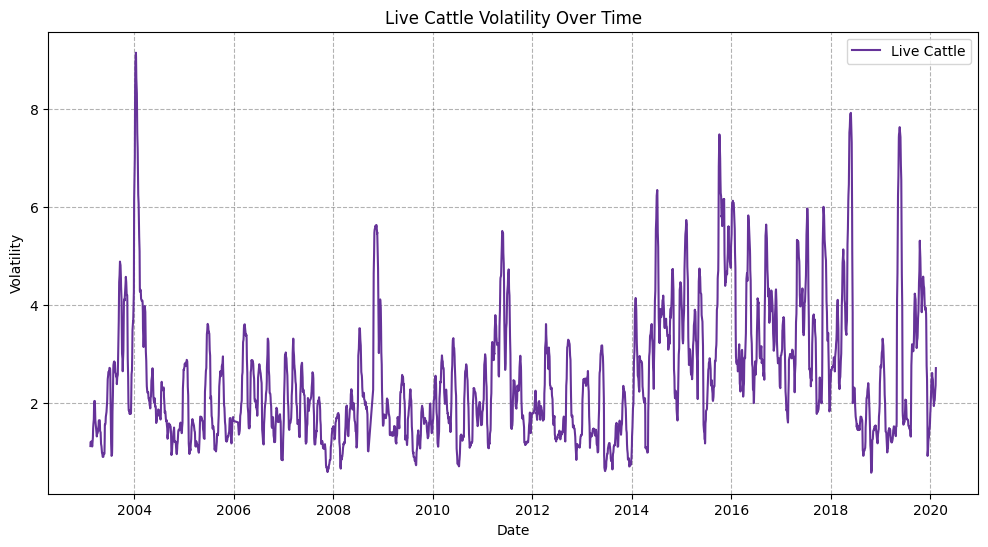

In [15]:
#vou plotar a volatilidade, dfv
for i, commodity in enumerate(dfv.columns[1:]):
    plt.figure(figsize=(12, 6))
    plt.plot(dfv['date'], dfv[commodity], label=commodity, c=colors[i])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'{commodity} Volatility Over Time')
    plt.grid(True, alpha = 0.3, linestyle ="--", c ='black')
    plt.legend()
    plt.show()

---

### Vou para a modelagem preditiva de preços da commodities:

### 1 - Escolho o melhor modelo para os dados. Vou testar alguns modelos de regressão e medir o desempenho deles.

In [27]:
# Convertendo a coluna 'date' para datetime e definindo como índice
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Lista de commodities
commodities = ['Sugar', 'Soybeans', 'Corn', 'Wheat', 'Coffee', 'Gold', 'Crude Oil', 'Lumber', 'Copper', 'Live Cattle']

# Função para calcular a média móvel e a volatilidade
def calculate_features(data, window=30):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    return pd.DataFrame({'price': data, 'MA': rolling_mean, 'volatility': rolling_std})

# Preparando os dados para cada commodity
commodity_data = {}
for commodity in commodities:
    commodity_data[commodity] = calculate_features(df[commodity])
    commodity_data[commodity].dropna(inplace=True)

In [28]:
# Pré-processamento dos dados
def preprocess_data(data):
    X = data[['MA', 'volatility']]
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [31]:
# Teste de modelos
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for commodity in commodities:
    print(f"\nAvaliando modelos para {commodity}:")
    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(commodity_data[commodity])

    commodity_results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
        mse_scores = -scores
        commodity_results[name] = np.mean(mse_scores)
        print(f"{name}: MSE = {np.mean(mse_scores):.4f} (+/- {np.std(mse_scores) * 2:.4f})")

    results[commodity] = commodity_results



Avaliando modelos para Sugar:
LinearRegression: MSE = 1.1941 (+/- 0.2970)
Ridge: MSE = 1.1941 (+/- 0.2970)
Lasso: MSE = 2.2141 (+/- 0.3129)
ElasticNet: MSE = 5.3718 (+/- 0.6134)
RandomForestRegressor: MSE = 1.0868 (+/- 0.1283)

Avaliando modelos para Soybeans:
LinearRegression: MSE = 2979.9380 (+/- 356.7212)
Ridge: MSE = 2979.9389 (+/- 357.0186)
Lasso: MSE = 2983.3955 (+/- 350.8708)
ElasticNet: MSE = 13534.1022 (+/- 1333.2690)
RandomForestRegressor: MSE = 2348.0697 (+/- 505.1231)

Avaliando modelos para Corn:
LinearRegression: MSE = 851.7596 (+/- 108.4960)
Ridge: MSE = 851.7639 (+/- 108.7185)
Lasso: MSE = 856.2737 (+/- 121.2309)
ElasticNet: MSE = 3661.6862 (+/- 359.9176)
RandomForestRegressor: MSE = 752.0614 (+/- 154.3737)

Avaliando modelos para Wheat:
LinearRegression: MSE = 1867.3553 (+/- 446.7611)
Ridge: MSE = 1867.3385 (+/- 446.3461)
Lasso: MSE = 1869.1378 (+/- 445.1433)
ElasticNet: MSE = 4869.9784 (+/- 981.4107)
RandomForestRegressor: MSE = 1475.9425 (+/- 361.0530)

Avaliando mo

In [32]:
# Treinamento do melhor modelo para cada commodity
best_models = {}

for commodity in commodities:
    best_model_name = min(results[commodity], key=results[commodity].get)
    print(f"\nMelhor modelo para {commodity}: {best_model_name}")

    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(commodity_data[commodity])

    best_model = models[best_model_name]
    best_model.fit(X_train_scaled, y_train)

    y_pred = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    best_models[commodity] = best_model

# Os melhores modelos estão agora armazenados no dicionário 'best_models'


Melhor modelo para Sugar: RandomForestRegressor
MSE: 0.8607
R2 Score: 0.9708

Melhor modelo para Soybeans: RandomForestRegressor
MSE: 2072.9757
R2 Score: 0.9775

Melhor modelo para Corn: RandomForestRegressor
MSE: 696.1881
R2 Score: 0.9714

Melhor modelo para Wheat: RandomForestRegressor
MSE: 1089.0037
R2 Score: 0.9655

Melhor modelo para Coffee: RandomForestRegressor
MSE: 66.3327
R2 Score: 0.9693

Melhor modelo para Gold: RandomForestRegressor
MSE: 1028.5243
R2 Score: 0.9954

Melhor modelo para Crude Oil: RandomForestRegressor
MSE: 17.8513
R2 Score: 0.9673

Melhor modelo para Lumber: RandomForestRegressor
MSE: 3302.3384
R2 Score: 0.9093

Melhor modelo para Copper: RandomForestRegressor
MSE: 0.0177
R2 Score: 0.9798

Melhor modelo para Live Cattle: RandomForestRegressor
MSE: 9.5666
R2 Score: 0.9826


### Vou utilizar o random forest para todas as commodities.

### 2 - Modelagem via random forest:

In [35]:
def calculate_features(data, window=30):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    return pd.DataFrame({'price': data, 'MA': rolling_mean, 'volatility': rolling_std})

commodity_data = {}
for commodity in commodities:
    commodity_data[commodity] = calculate_features(df[commodity])
    commodity_data[commodity].dropna(inplace=True)

# Pré-processamento dos dados
def preprocess_data(data):
    X = data[['MA', 'volatility']]
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [36]:
# Treinamento e avaliação do modelo Random Forest
rf_models = {}
results = {}

for commodity in commodities:
    print(f"\nTreinando modelo para {commodity}:")
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = preprocess_data(commodity_data[commodity])

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    y_pred = rf_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    rf_models[commodity] = {'model': rf_model, 'scaler': scaler}
    results[commodity] = {'mse': mse, 'r2': r2}

# Imprimindo um resumo dos resultados
print("\nResumo dos resultados:")
for commodity, metrics in results.items():
    print(f"{commodity}:")
    print(f"  MSE: {metrics['mse']:.4f}")
    print(f"  R2 Score: {metrics['r2']:.4f}")

# Os modelos Random Forest treinados estão armazenados no dicionário 'rf_models'


Treinando modelo para Sugar:
MSE: 0.8607
R2 Score: 0.9708

Treinando modelo para Soybeans:
MSE: 2072.9757
R2 Score: 0.9775

Treinando modelo para Corn:
MSE: 696.1881
R2 Score: 0.9714

Treinando modelo para Wheat:
MSE: 1089.0037
R2 Score: 0.9655

Treinando modelo para Coffee:
MSE: 66.3327
R2 Score: 0.9693

Treinando modelo para Gold:
MSE: 1028.5243
R2 Score: 0.9954

Treinando modelo para Crude Oil:
MSE: 17.8513
R2 Score: 0.9673

Treinando modelo para Lumber:
MSE: 3302.3384
R2 Score: 0.9093

Treinando modelo para Copper:
MSE: 0.0177
R2 Score: 0.9798

Treinando modelo para Live Cattle:
MSE: 9.5666
R2 Score: 0.9826

Resumo dos resultados:
Sugar:
  MSE: 0.8607
  R2 Score: 0.9708
Soybeans:
  MSE: 2072.9757
  R2 Score: 0.9775
Corn:
  MSE: 696.1881
  R2 Score: 0.9714
Wheat:
  MSE: 1089.0037
  R2 Score: 0.9655
Coffee:
  MSE: 66.3327
  R2 Score: 0.9693
Gold:
  MSE: 1028.5243
  R2 Score: 0.9954
Crude Oil:
  MSE: 17.8513
  R2 Score: 0.9673
Lumber:
  MSE: 3302.3384
  R2 Score: 0.9093
Copper:
  MSE

### Vou criar um gráfico com os dados reais e as previsões para um período já conhecido, a fim de verificar a qualidade da modelagem. Quanto mais próximo os valores da dispersão estiverem da linha tracejada vermelha maior a precisão da modelagem para a commodity em questão.

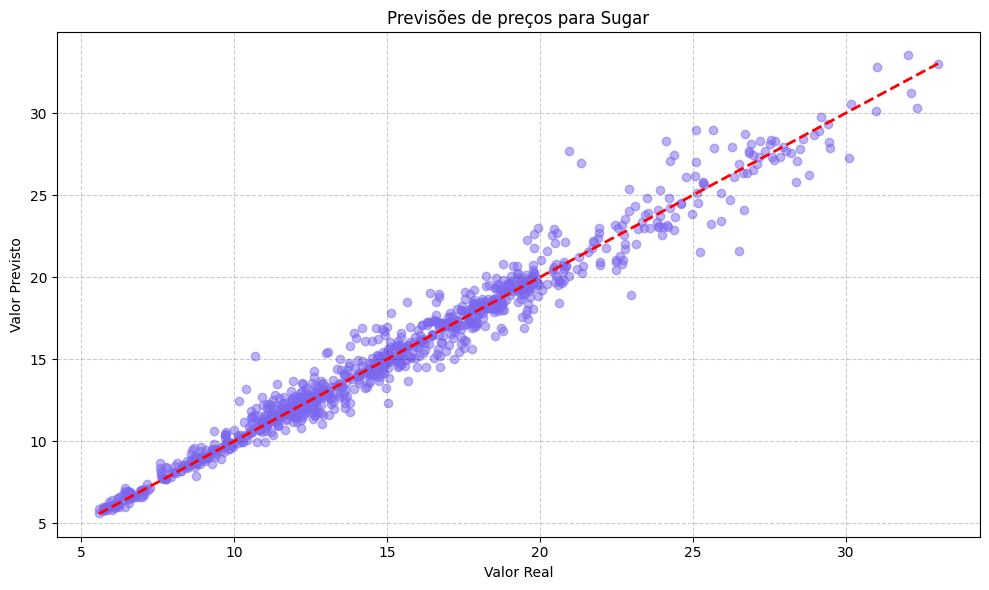

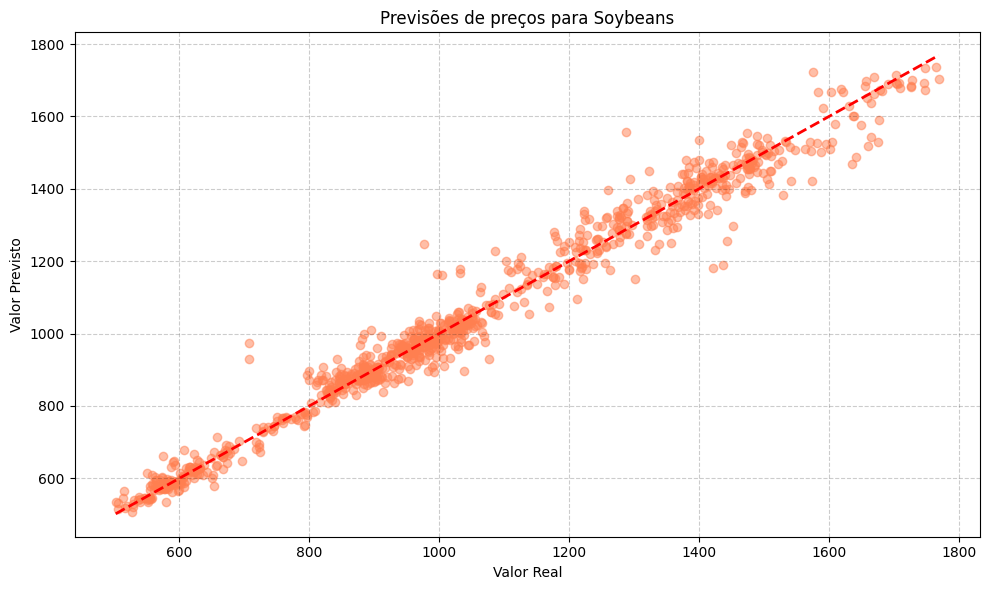

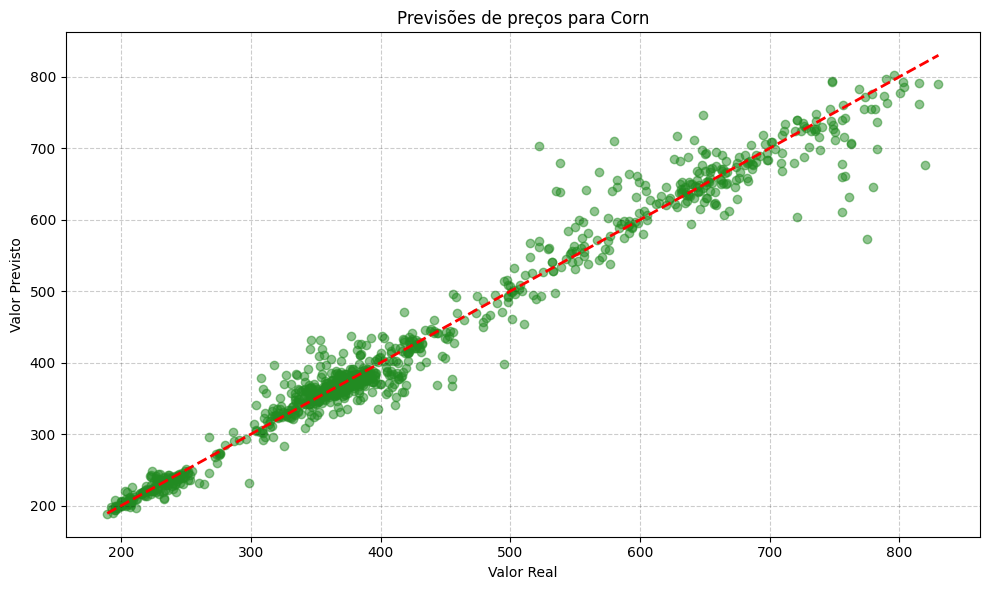

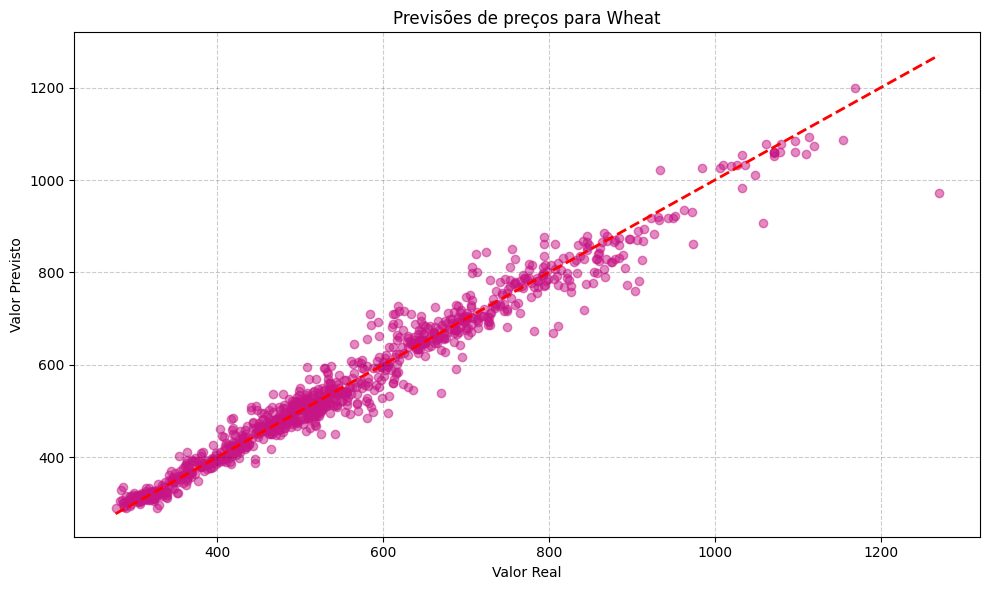

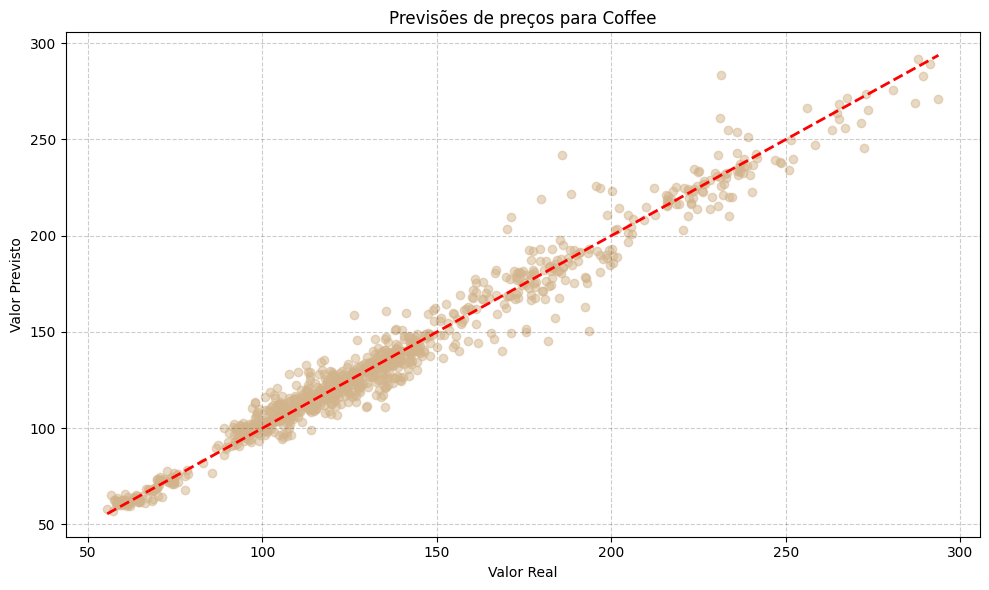

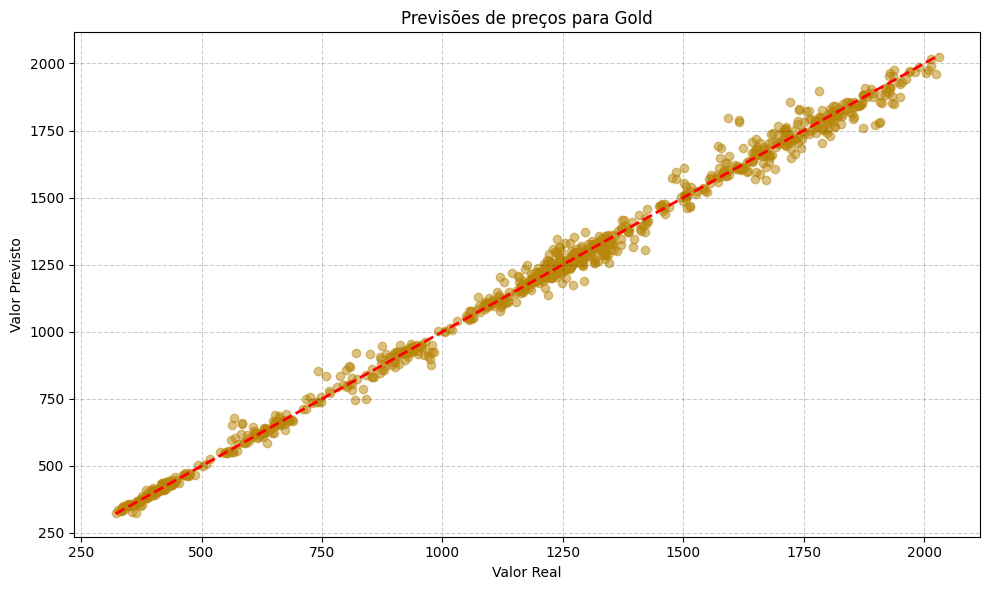

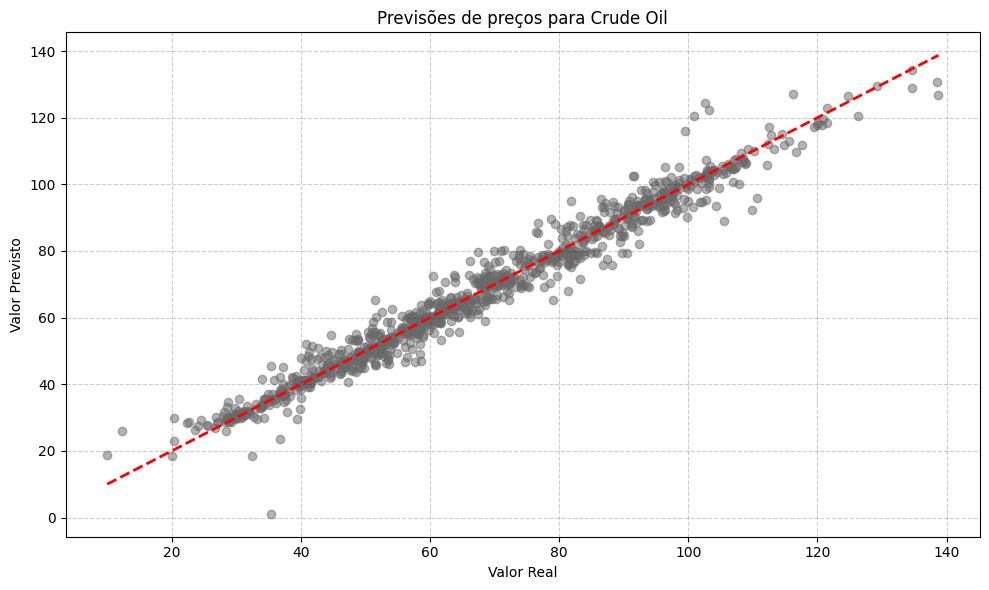

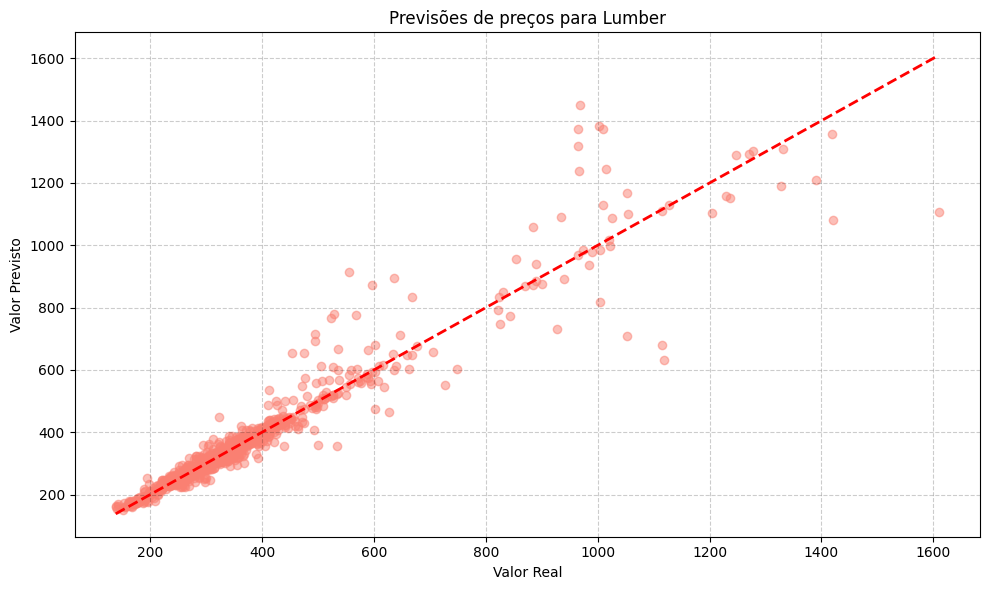

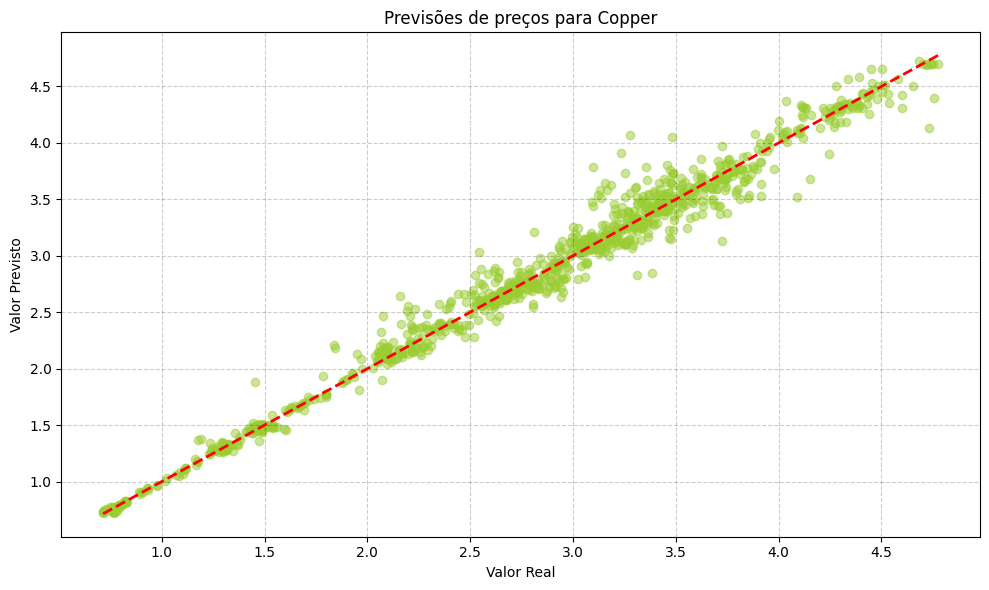

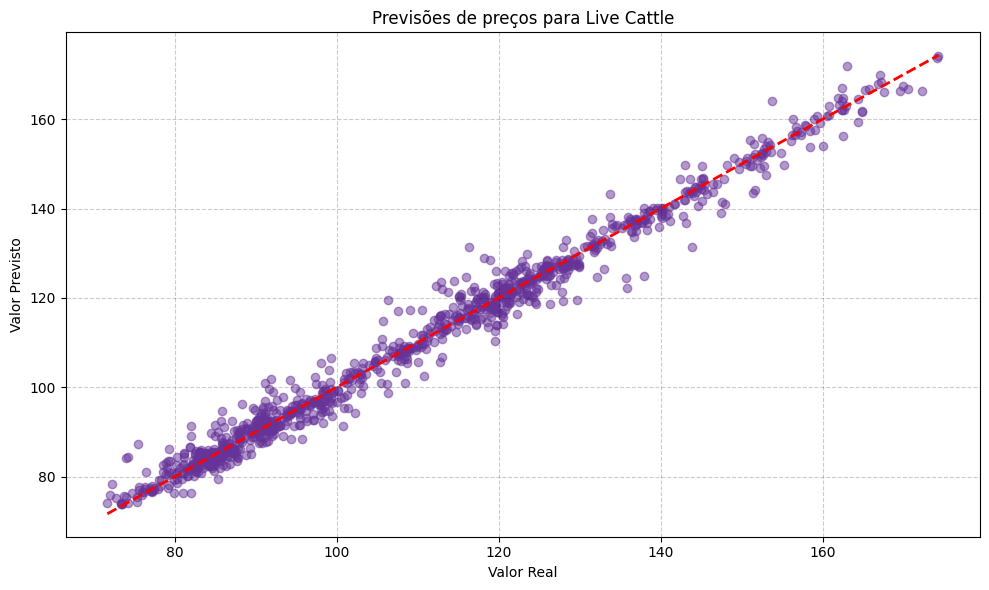

In [37]:
def plot_predictions(commodity, color):
    data = commodity_data[commodity]
    X = data[['MA', 'volatility']]
    y = data['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = rf_models[commodity]['model']
    y_pred = model.predict(X_test_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color=color)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Previsto')
    plt.title(f'Previsões de preços para {commodity}')
    plt.grid(True, alpha=0.2, linestyle='--', c='black')
    plt.tight_layout()
    plt.show()

# Criar um gráfico para cada commodity com a cor correspondente
for commodity, color in zip(commodities, colors):
    plot_predictions(commodity, color)

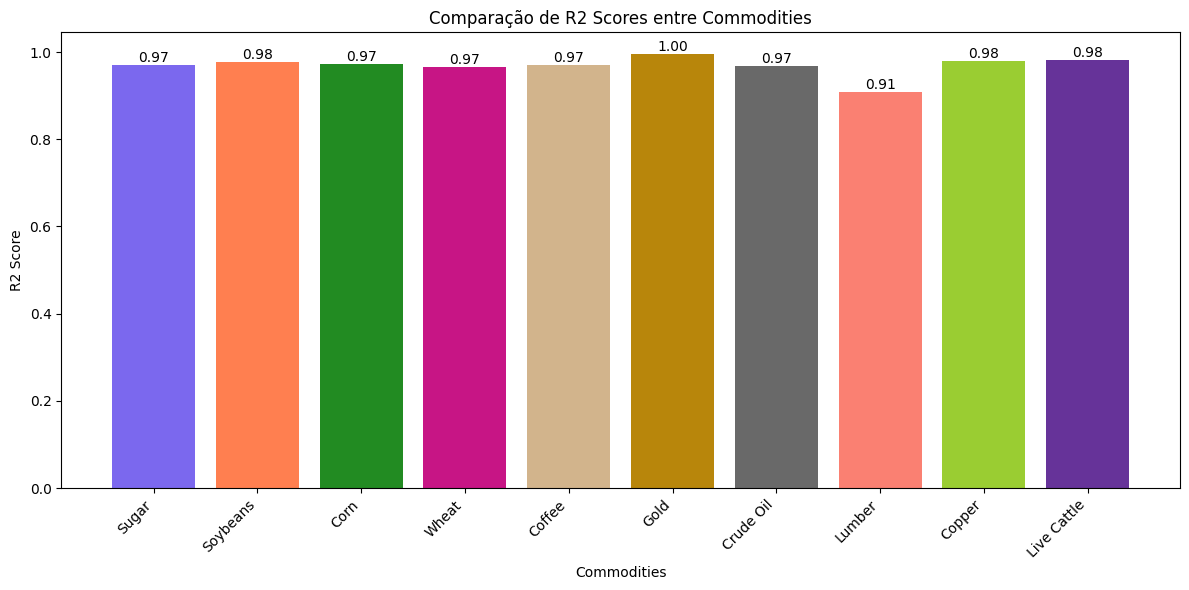

In [38]:
# Gráfico de barras para comparar R2 scores com as cores específicas
r2_scores = [results[commodity]['r2'] for commodity in commodities]

plt.figure(figsize=(12, 6))
bars = plt.bar(commodities, r2_scores, color=colors)
plt.title('Comparação de R2 Scores entre Commodities')
plt.xlabel('Commodities')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adicionar valores em cima das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.show()

### O gráfico do R^2 indica simplesmente o quanto o modelo explica o preço com base nesses dois parâmetros colocados.

### Vou prever o futuro dos preços com base nesse modelo treinado:

In [39]:
from datetime import timedelta, datetime

In [44]:
def generate_future_data(commodity_data, days=100):
    last_date = commodity_data.index[-1]

    # Verificar se o último índice é um datetime
    if not isinstance(last_date, (datetime, pd.Timestamp)):
        # Se não for, vamos usar a data atual como ponto de partida
        last_date = pd.Timestamp.now().floor('D')

    future_dates = [last_date + timedelta(days=i) for i in range(1, days+1)]

    # Usando os últimos valores de MA e volatilidade como base para projeções futuras
    last_ma = commodity_data['MA'].iloc[-1]
    last_volatility = commodity_data['volatility'].iloc[-1]

    # Gerando dados futuros com alguma variação aleatória
    future_ma = [last_ma + np.random.normal(0, last_ma * 0.01) for _ in range(days)]
    future_volatility = [last_volatility + np.random.normal(0, last_volatility * 0.01) for _ in range(days)]

    future_data = pd.DataFrame({
        'MA': future_ma,
        'volatility': future_volatility
    }, index=future_dates)

    return future_data

In [45]:
def predict_future(commodity, days=100):
    data = commodity_data[commodity]
    future_data = generate_future_data(data, days)

    model = rf_models[commodity]['model']
    scaler = rf_models[commodity]['scaler']

    future_data_scaled = scaler.transform(future_data)
    predictions = model.predict(future_data_scaled)

    future_data['predicted_price'] = predictions
    return future_data

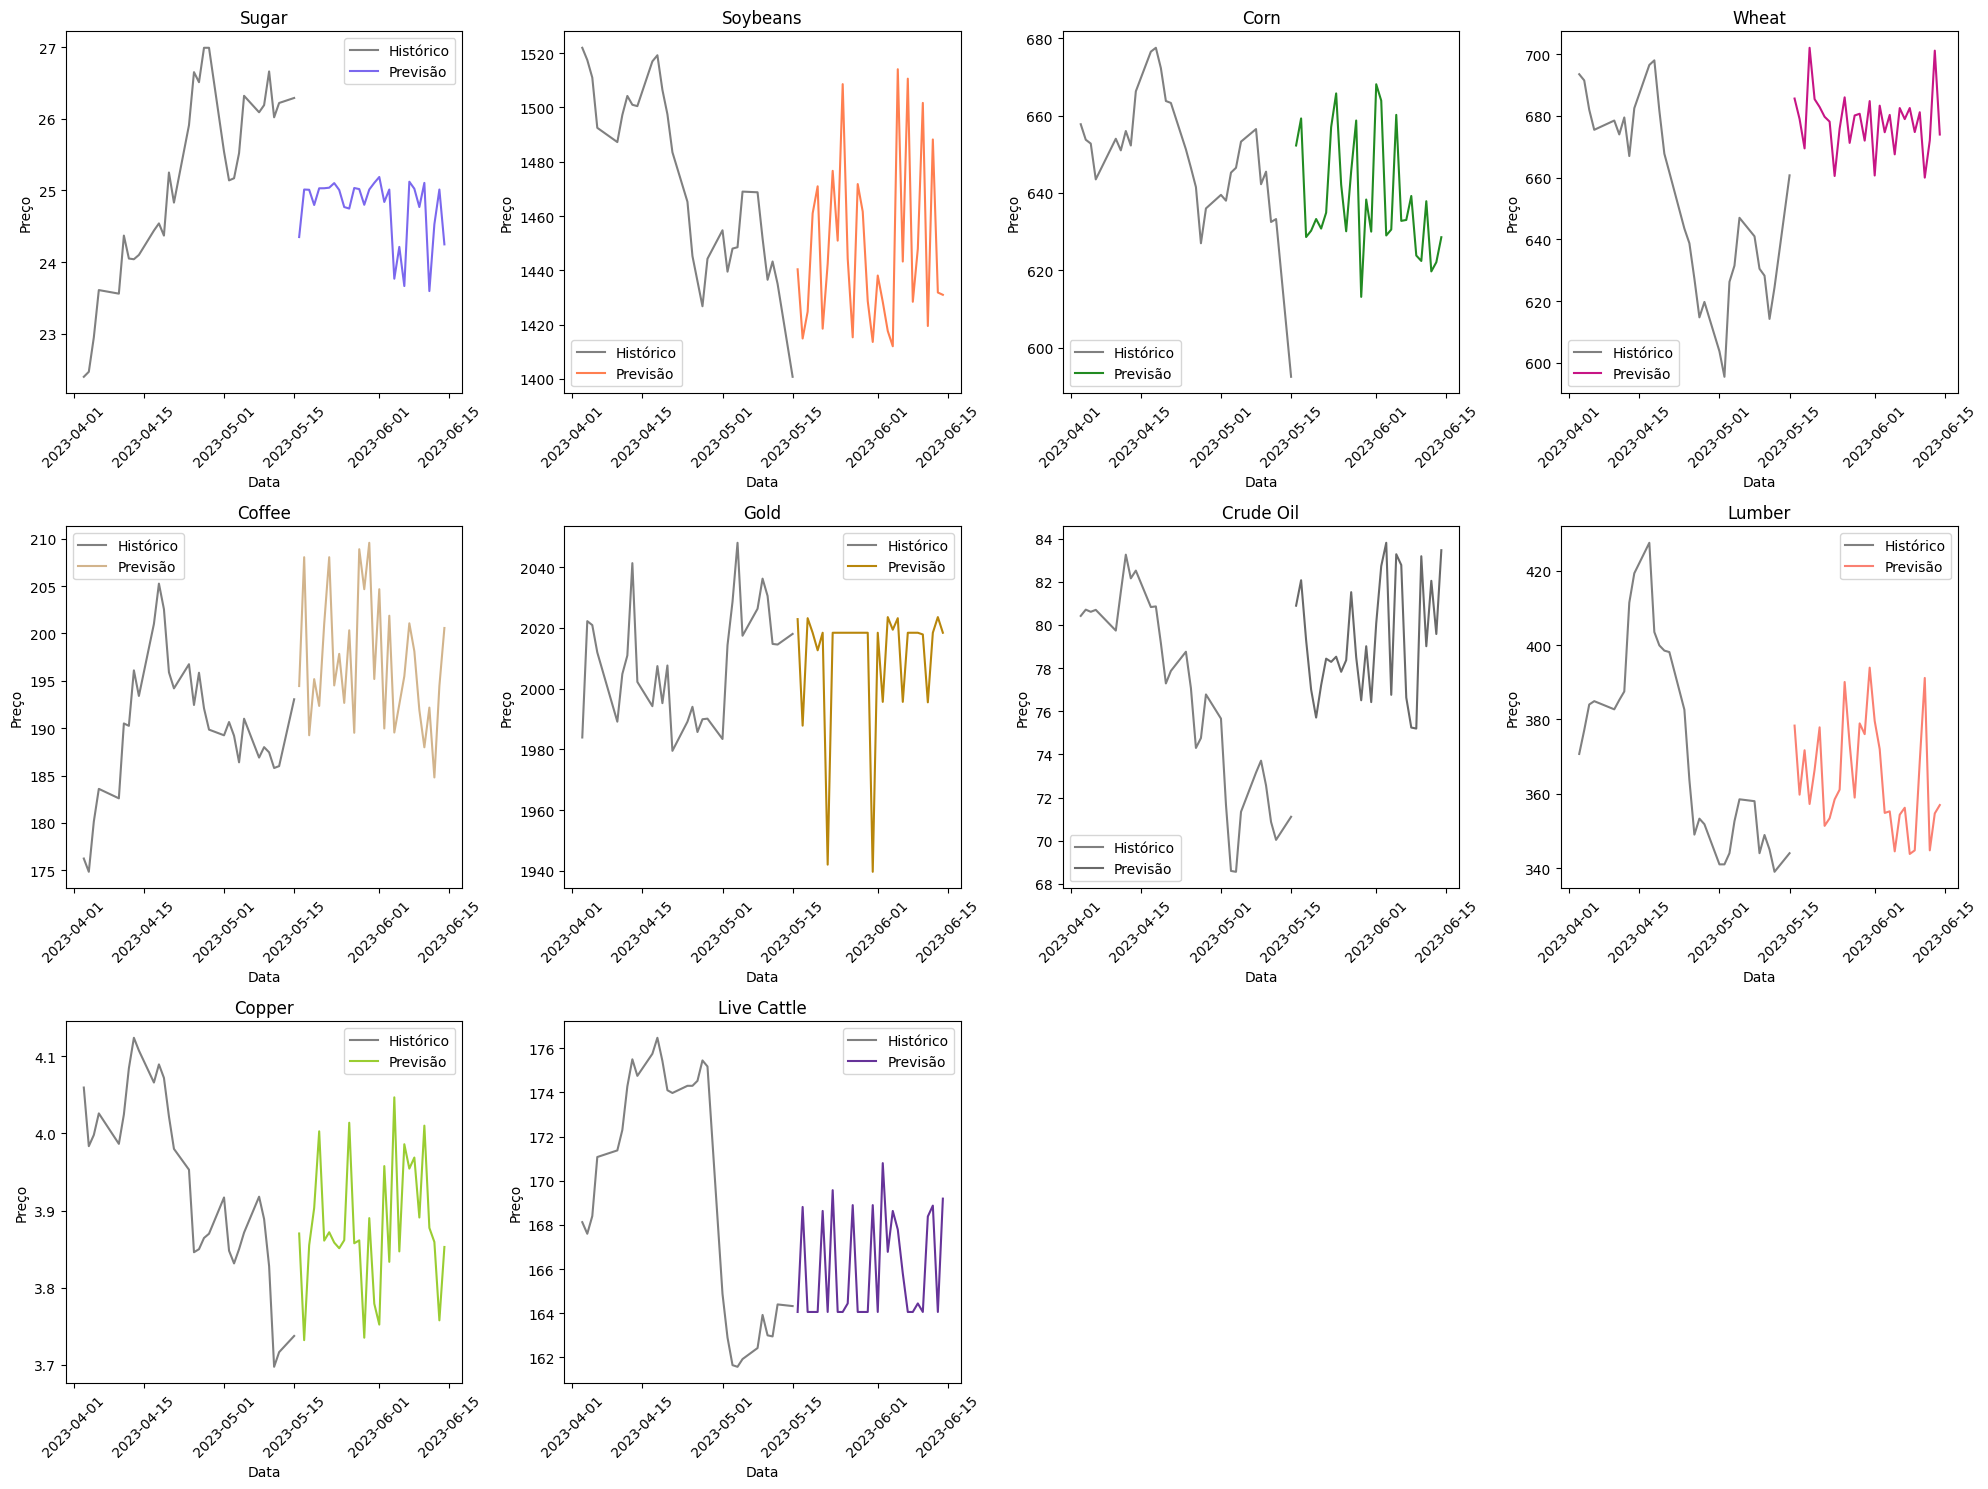

In [42]:
# Fazer previsões e plotar resultados para cada commodity
plt.figure(figsize=(20, 15))

for i, (commodity, color) in enumerate(zip(commodities, colors)):
    future_predictions = predict_future(commodity)

    plt.subplot(3, 4, i+1)
    plt.plot(commodity_data[commodity].index[-30:], commodity_data[commodity]['price'][-30:], label='Histórico', color='gray')
    plt.plot(future_predictions.index, future_predictions['predicted_price'], label='Previsão', color=color)
    plt.title(commodity)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlabel('Data')
    plt.ylabel('Preço')

plt.tight_layout()
plt.show()

In [46]:
# Imprimir as previsões para os próximos 100 dias para cada commodity
print("\nPrevisões para os próximos 100 dias:")
for commodity in commodities:
    future_predictions = predict_future(commodity, days=100)
    print(f"\n{commodity}:")
    print(future_predictions['predicted_price'])


Previsões para os próximos 100 dias:

Sugar:
2023-05-16    25.295601
2023-05-17    25.302601
2023-05-18    25.023801
2023-05-19    25.023801
2023-05-20    25.030301
                ...    
2023-08-19    24.749300
2023-08-20    24.212100
2023-08-21    24.349700
2023-08-22    25.023801
2023-08-23    25.003701
Name: predicted_price, Length: 100, dtype: float64

Soybeans:
2023-05-16    1501.6875
2023-05-17    1433.7125
2023-05-18    1424.5450
2023-05-19    1425.4325
2023-05-20    1467.8600
                ...    
2023-08-19    1423.5075
2023-08-20    1438.7705
2023-08-21    1420.5100
2023-08-22    1438.4500
2023-08-23    1419.7100
Name: predicted_price, Length: 100, dtype: float64

Corn:
2023-05-16    630.1450
2023-05-17    663.9600
2023-05-18    625.2725
2023-05-19    638.3950
2023-05-20    631.0875
                ...   
2023-08-19    622.9150
2023-08-20    624.1250
2023-08-21    627.9425
2023-08-22    664.0625
2023-08-23    619.9850
Name: predicted_price, Length: 100, dtype: float64

W

### Veja como ficou interessante!